# Importando Librerias

In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#import tensorflow as tf
import os
import numpy as np 
import pandas as pd
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from keras.models import Model,Sequential
from keras.layers import CuDNNLSTM, Dense, Bidirectional,LSTM, Input, Embedding, GlobalMaxPooling1D,Dropout,GlobalAveragePooling1D,concatenate
from keras.optimizers import Adam
tqdm.pandas()
from gensim.models import KeyedVectors
import operator
import gc
import matplotlib.pyplot as plt

Using TensorFlow backend.


Imprimiendo las direcciones de la data

In [2]:

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/quora-insincere-questions-classification/test.csv
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin
/kaggle/input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/paragram_300_sl999.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/README.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec


Importando training y test set

In [3]:
train=pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test=pd.read_csv("../input/quora-insincere-questions-classification/test.csv")
trainx=train.drop(['qid','target'],axis=1)
trainy=train['target']
testx=train.drop(['qid'],axis=1)

Funcion que crea vocabulario de las palabras en las preguntas del set

In [4]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [5]:
sentences = train["question_text"].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)


100%|██████████| 1306122/1306122 [00:06<00:00, 217325.71it/s]


Primeras 8 palabras encontradas en el vocabulario con la frcuencia que aparecen

In [6]:
print({k: vocab[k] for k in list(vocab)[:8]})

{'How': 261930, 'did': 33489, 'Quebec': 97, 'nationalists': 91, 'see': 9003, 'their': 34810, 'province': 124, 'as': 55047}


Cargando el embedding glove

In [7]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == '../input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

In [8]:
embed_glove = load_embed('../input/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt')

Funcion para saber que porcentaje de palabras del vocabulario se encuentran en el embedding

In [9]:
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.3%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.3%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [10]:
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)

Glove : 
Found embeddings for 33.024% of vocab
Found embeddings for  88.148% of all text


Palabras que no se encuentran en el embedding mas frecuentes 

In [11]:
oov_glove[:10]

[('India?', 16384),
 ('it?', 12900),
 ("What's", 12425),
 ('do?', 8753),
 ('life?', 7753),
 ('you?', 6295),
 ('me?', 6202),
 ('them?', 6140),
 ('time?', 5716),
 ('world?', 5386)]

# PREPROCESAMIENTO DE DATOS

Se remueven signos de las palabras del vocabulario

In [12]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [13]:
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

In [14]:
print("Glove :")
print(unknown_punct(embed_glove, punct))

Glove :
“ ” ’ ∞ θ ÷ α • à − β ∅ ³ π ‘ ₹ ´ ° £ € × ™ √ ² — – 


In [15]:
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

In [16]:
train["question_text"] = train["question_text"].progress_apply(lambda x: clean_text(x))
sentences = train["question_text"].apply(lambda x: x.split())
vocab = build_vocab(sentences)

100%|██████████| 1306122/1306122 [00:05<00:00, 222306.25it/s]


Porcentaje de palabras del vocabulario en el embedding una vez se han removido los signos

In [17]:
oov_glove = check_coverage(vocab,embed_glove)

Found embeddings for 70.986% of vocab
Found embeddings for  99.421% of all text


Nuevas palabras que no se encuentran en el embedding mas frecuentes 

In [18]:
oov_glove[:50]

[('Quorans', 858),
 ('Brexit', 493),
 ('cryptocurrencies', 481),
 ('Redmi', 379),
 ('…', 210),
 ('OnePlus', 125),
 ('UCEED', 123),
 ('GDPR', 107),
 ('Blockchain', 107),
 ('demonetisation', 106),
 ('Pokémon', 106),
 ('Coinbase', 104),
 ('BNBR', 99),
 ('Adityanath', 99),
 ('Machedo', 99),
 ('–', 93),
 ('Boruto', 93),
 ('DCEU', 89),
 ('ethereum', 88),
 ('IIEST', 85),
 ('SJWs', 81),
 ('Qoura', 78),
 ('√', 70),
 ('fiancé', 70),
 ('LNMIIT', 67),
 ('Upwork', 66),
 ('Zerodha', 65),
 ('etc…', 64),
 ('bhakts', 63),
 ('Doklam', 62),
 ('NICMAR', 59),
 ('Vajiram', 59),
 ('Unacademy', 58),
 ('MUOET', 56),
 ('Kavalireddi', 55),
 ('chsl', 55),
 ('HackerRank', 52),
 ('π', 52),
 ('AlShamsi', 52),
 ('Bhakts', 51),
 ('wwwyoutubecom', 50),
 ('Litecoin', 48),
 ('Awdhesh', 48),
 ('Cryptocurrency', 47),
 ('eLitmus', 47),
 ('Jiren', 46),
 ('bSC', 46),
 ('altcoins', 45),
 ('Ryzen', 45),
 ('×', 45)]

Se puede observar que son palabras de nombres propios con lo cual tiene sentido que no se encuentren en el embedding

Se pone en minusculas las palabras en el vocabulario y se observa una mejora de casi un 1% en las palabras que se encuentran en el embedding

In [19]:
train['lowered_question'] = train['question_text'].apply(lambda x: x.lower())

In [20]:
def add_lower(embedding, vocab):
    count = 0
    for word in vocab:
        if word in embedding and word.lower() not in embedding:  
            embedding[word.lower()] = embedding[word]
            count += 1
    print(f"Added {count} words to embedding")

In [21]:
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
add_lower(embed_glove, vocab)
oov_glove = check_coverage(vocab, embed_glove)

Glove : 
Found embeddings for 70.986% of vocab
Found embeddings for  99.421% of all text
Added 17890 words to embedding
Found embeddings for 71.660% of vocab
Found embeddings for  99.440% of all text


In [22]:
oov_glove = check_coverage(vocab,embed_glove)

Found embeddings for 71.660% of vocab
Found embeddings for  99.440% of all text


# ENTRENAMIENTO DEL MODELO

In [23]:
len_voc = 95000
max_len = 60
epochs = 10
batch_size = 512

Se le aplica al training set los cambios del preprocesamiento 

In [24]:
train['treated_question'] = train['question_text'].apply(lambda x: x.lower())

In [25]:
train['treated_question'] = train['treated_question'].apply(lambda x: clean_text(x))

Funcion para convertir el input en enteros

In [26]:
def make_treated_data(X):
    t = Tokenizer(num_words=len_voc, filters='')
    t.fit_on_texts(X)
    X = t.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=max_len)
    return X, t.word_index

In [27]:
X_treated, word_index_treated = make_treated_data(train['treated_question'])

In [28]:
y = train['target'].values

In [29]:
X_t_train, X_t_val, y_train, y_val = train_test_split(X_treated, y, test_size=0.1, random_state=420)

Matriz de embedding

In [30]:
def make_embed_matrix(embeddings_index, word_index, len_voc):
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    
    for word, i in word_index.items():
        if i >= len_voc:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [31]:
embedding_treated = make_embed_matrix(embed_glove, word_index_treated, len_voc)
del word_index_treated
gc.collect()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


10

Modelo

In [32]:
def make_model(embedding_matrix, embed_size=300, loss='binary_crossentropy'):
    inp    = Input(shape=(max_len,))
    x      = Embedding(len_voc, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x      = Bidirectional(LSTM(128, return_sequences=True))(x)
    x      = Bidirectional(LSTM(64, return_sequences=True))(x)
    avg_pl = GlobalAveragePooling1D()(x)
    max_pl = GlobalMaxPooling1D()(x)
    concat = concatenate([avg_pl, max_pl])
    dense  = Dense(64, activation="relu")(concat)
    drop   = Dropout(0.1)(concat)
    output = Dense(1, activation="sigmoid")(concat)
    
    model  = Model(inputs=inp, outputs=output)
    model.compile(loss=loss, optimizer=Adam(lr=0.0001), metrics=['binary_accuracy'])
    return model

In [33]:
model_treated = make_model(embedding_treated)

Parametros del modelo

In [34]:
model_treated.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 60, 300)      28500000    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 256)      439296      embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 60, 128)      164352      bidirectional_1[0][0]            
____________________________________________________________________________________________

Entrenando el modelo

In [35]:
history= model_treated.fit(X_t_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=[X_t_val,y_val])

Train on 1175509 samples, validate on 130613 samples
Epoch 1/10
1175509/1175509 [==============================] - 612s 521us/step - loss: 0.1311 - binary_accuracy: 0.9503 - val_loss: 0.1184 - val_binary_accuracy: 0.9521
Epoch 2/10
1175509/1175509 [==============================] - 593s 505us/step - loss: 0.1137 - binary_accuracy: 0.9547 - val_loss: 0.1112 - val_binary_accuracy: 0.9557
Epoch 3/10
1175509/1175509 [==============================] - 592s 503us/step - loss: 0.1089 - binary_accuracy: 0.9566 - val_loss: 0.1080 - val_binary_accuracy: 0.9562
Epoch 4/10
1175509/1175509 [==============================] - 594s 505us/step - loss: 0.1053 - binary_accuracy: 0.9580 - val_loss: 0.1069 - val_binary_accuracy: 0.9575
Epoch 5/10
1175509/1175509 [==============================] - 582s 495us/step - loss: 0.1024 - binary_accuracy: 0.9590 - val_loss: 0.1031 - val_binary_accuracy: 0.9588
Epoch 6/10
1175509/1175509 [==============================] - 585s 498us/step - loss: 0.1001 - binary_accur

Grafico del accuracy del training y validation set

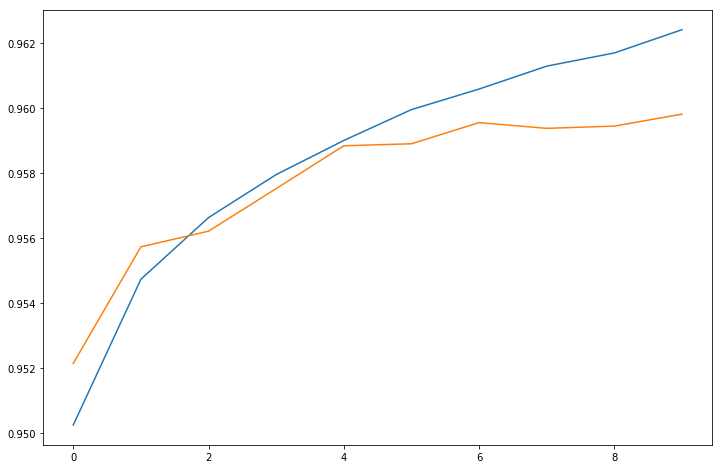

In [36]:
plt.figure(figsize=(12,8))
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Test Accuracy')
plt.show()

# PREDICCION

In [37]:
test['treated_question'] = test['question_text'].apply(lambda x: x.lower())
test['treated_question'] = test['treated_question'].apply(lambda x: clean_text(x))
X_test, word_index_treated = make_treated_data(test['treated_question'])

In [38]:
test['treated_question'][0]

'why do so many women become so rude and arrogant when they get just a little bit of wealth and power'

In [39]:
pred_t_val = model_treated.predict(X_test, batch_size=512, verbose=1)


375806/375806 [==============================] - 72s 191us/step


In [40]:
print(pred_t_val.shape)
print(len(test['qid']))
#submission = []
submission=np.zeros((375806,1))
for i in range(375806):
    if pred_t_val[i]>0.5:
        submission[i]=1
    '''
    else:
        submission.append([test['qid'][i],0])    '''  

(375806, 1)
375806


In [41]:
print(len(submission))
print(submission.flatten().shape)

375806
(375806,)


In [42]:
#y_te = (np.array(pred_t_val) > 0.5).astype(np.int)

submit_df = pd.DataFrame({"qid": test["qid"], "prediction": submission.flatten().astype(np.int)})
submit_df.to_csv("submission.csv", index=False)